# Project 4

Executive summary
https://docs.google.com/presentation/d/15EcRlAdKEno6WIs6bNX0qjR-nBhtpI0NSPC6uFfdkz0/edit?usp=sharing


Some key points:
* In summary the job searches greatly impacted my findings. The job search resulted in many data engineering, data consulting jobs that were not directly data science related. This would have had an impact on the first question where i attempted to predict what words would result in above median salary. The median salary of my data was $108k, which was impacted by soloutions architects and data consulting jobs.

## Scraping
* Built functions for scraping
* Used beautiful soup to scrape summaries, location, salaries, titles, and detailed job advertisement
* Job searches included: data scientist, data analyst, data engineer, data consultant, neural network, machine learning, big data, artificial intelligence, business intelligence

In [2]:
from scrapy.selector import Selector
from scrapy.http import HtmlResponse

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
sns.set_style("whitegrid")
%matplotlib inline  

In [3]:
# Function to create hyperlinks for each search
def jobsearch(search_terms):
    search_links = []
    for terms in search_terms:
        search_links.append(indeed_link+terms)
    return search_links
# jobsearch(search_terms)

In [4]:
# Finding number of jobs
def max_pagenum(search):
    r = requests.get(search)
    soup = BeautifulSoup(r.text, 'lxml')
    jobs = int(soup.find("div",{"id":"searchCount"}).text.split()[-1].replace(",",""))
    max_pages = jobs - jobs%10
    return max_pages

In [5]:
# def links(search):
def searchlist(search):
    searchlist = []
    for num in range(10,max_pagenum(search),10):
        searchlist.append(search + str(num))
    return searchlist

In [6]:
## Function that gets job texts

def get_text(url):
    r = requests.get(url)
#     # turn into a BeautifulSoup object
    soup = BeautifulSoup(r.text, 'lxml')
#     soup = BeautifulSoup(site, 'html.parser')
    for i in soup.find_all("script"):
        i.decompose()
    for i in soup.find_all("style"):
        i.decompose()
    for i in soup.find_all("noscript"):
        i.decompose()
#     for i in soup.find_all("div"):
#         i.decompose()
    for i in soup.find_all("meta"):
        i.decompose()
    text = soup.get_text()
    lines = (line.strip() for line in text.splitlines()) 
    lines = [l for l in lines if l != '']
    cleaned = ' '.join(lines)
    return cleaned

Scraping

In [ ]:
# Job search keyword
indeed_link = "https://au.indeed.com/jobs?q="
# search_terms = ["Data+Scientist&start=","Neural+Network&start="]

search_terms = ["Data+Scientist&start=","Data+analyst&start=","Data+Engineer&start=","Data+Consultant&start=", "Neural+Network&start=",
                "Machine+Learning&start=","Big+Data&start=","Artificial+Intelligence&start=","Business+Intelligence&start="]

In [ ]:
# make request for that page
json = []

for search in jobsearch(search_terms):
    print("now scraping search",search)
    for x in searchlist(search):
        print("page num",x,"out of",max_pagenum(x))
        r = requests.get(x)
        soup = BeautifulSoup(r.text, 'lxml')

        for job_card in soup.find_all("div",{"class":"row"}):
            #Title
            try:
                title = job_card.find("a").text
            except:
                title = "NA"
            #Company
            try:
                company = job_card.find("span").text.strip()
            except:
                company = "NA"
            #Location
            try:
                location = job_card.find("span", {"class": "location"}).text
            except:
                location = "NA"
            #Summary
            try:
                summary = job_card.find("span", {"class": "summary"}).text.strip()
            except:
                summary = "NA"
            # Salary
            try:
                salary = job_card.find("span",{"class":"no-wrap"}).text.strip()
            except:
                salary = "NA"
            try:
                keywordsearch = search
            except:
                keywordsearch = "NA"
            # Description
            job_links = []
            job_links.append( "https://au.indeed.com/viewjob?jk={}".format(job_card.get("data-jk")))
            for text in job_links:
                try:
                    description = get_text(text)      
                except:
                    description = "NA"
            job = {"title": title,
                 "company":company,
                 "location":location,
                 "summary":summary,"description":description,"salary": salary, "search": keywordsearch}
#             job = {"title": title,
#                          "company":company,
#                          "location":location,
#                          "summary":summary,"salary": salary, "search": keywordsearch}
            json.append(job)

df = pd.DataFrame(json)

In [ ]:
df.tail()

In [ ]:
# df.to_csv("./indeedscrape020518.csv")

## Question 1
Approach is to predict whether salary will be above or below median salary depending on data in the job description. The median salary is approximately $108k

### EDA
* 17,000 jobs scraped from 9 job searches using Beautiful soup
* Description, salary, title, location, job page, summary
* Only 5,600 unique values, only (20%) with salary 1,100
* Cleaned  salary, converting to annual salary
* Cleaned cities
* Cleaned job titles using function, 40% jobs categoriesed into distinct categories
* Dropped salary outliers, those that are more than 4 standard deviations from mean (6 removed >$300k)

#### Initial EDA

In [8]:
df = pd.read_csv("./indeedscrape020518.csv", index_col= 0)
# df.drop(columns = " ",axis =1, inplace = True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17101 entries, 0 to 17100
Data columns (total 7 columns):
company        17101 non-null object
description    17101 non-null object
location       17101 non-null object
salary         4208 non-null object
search         17101 non-null object
summary        17101 non-null object
title          17101 non-null object
dtypes: object(7)
memory usage: 1.0+ MB


In [10]:
df.head(10)

,company,description,location,salary,search,summary,title
0,ANZ Banking Group,Lead Data Scientist/Data Architect - Chengdu j...,Sydney NSW,NaN,https://au.indeed.com/jobs?q=Data+Scientist&st...,An exciting opportunity has just come for you ...,Lead Data Scientist/Data Architect - Chengdu
1,Sunraysia Environmental,Soil Scientist/Soil Surveyor job - Sunraysia E...,Mildura VIC,"$70,000 - $90,000 a year",https://au.indeed.com/jobs?q=Data+Scientist&st...,Willing to use our digital data recording syst...,Soil Scientist/Soil Surveyor
2,AVT Resources Pty Ltd,Chemistry Laboratory Technician/Analyst job - ...,Darwin NT,$41 - $45 an hour,https://au.indeed.com/jobs?q=Data+Scientist&st...,Entering data and exporting results to the sys...,Chemistry Laboratory Technician/Analyst
3,CSIRO,Data Engineer - Machine Learning job - CSIRO -...,Australia,"$128,000 a year",https://au.indeed.com/jobs?q=Data+Scientist&st...,Designing and developing data streaming pipeli...,Data Engineer - Machine Learning
4,Deloitte,Data Analyst job - Deloitte - Melbourne VIC | ...,Melbourne VIC,"$80,000 a year",https://au.indeed.com/jobs?q=Data+Scientist&st...,"Be the bridge between Business SME, data scien...",Data Analyst
5,BuildingIQ,Data Scientist job - BuildingIQ - Sydney NSW |...,Sydney NSW,NaN,https://au.indeed.com/jobs?q=Data+Scientist&st...,We are looking for a Data Scientist to be a pa...,Data Scientist
6,Fortune Select,Data Scientist job - Fortune Select - Sydney N...,Sydney NSW,NaN,https://au.indeed.com/jobs?q=Data+Scientist&st...,Experience using and maintaining AWS environme...,Data Scientist
7,BCG Digital Ventures,Data Scientist - Machine Learning Data Platfor...,Sydney NSW,NaN,https://au.indeed.com/jobs?q=Data+Scientist&st...,We are looking for an exceptional Data Scienti...,Data Scientist - Machine Learning Data Platform
8,Arup,Data Scientist job - Arup - Sydney NSW | Indee...,Sydney NSW,NaN,https://au.indeed.com/jobs?q=Data+Scientist&st...,Data Scientist (SYD0000DO). We are looking for...,Data Scientist
9,Macquarie University,Data Science Research Engineer job - Macquarie...,Macquarie University NSW,"$100,706 - $112,058 a year",https://au.indeed.com/jobs?q=Data+Scientist&st...,We are seeking a Data Science Research Enginee...,Data Science Research Engineer


In [11]:
# Regex to remove digits from the description
df["description"].replace("\d", "",regex = True, inplace = True)

In [12]:
df.shape

(17101, 7)

In [13]:
# make sure everything is in the same format to perform Regex on description column later. Keep location as we will do other cleaning
df['company'] = df['company'].str.lower()
df['description'] = df['description'].str.lower()
df['search'] = df['search'].str.lower()
df['summary'] = df['summary'].str.lower()
df['title'] = df['title'].str.lower()

In [14]:
df.head()

,company,description,location,salary,search,summary,title
0,anz banking group,lead data scientist/data architect - chengdu j...,Sydney NSW,NaN,https://au.indeed.com/jobs?q=data+scientist&st...,an exciting opportunity has just come for you ...,lead data scientist/data architect - chengdu
1,sunraysia environmental,soil scientist/soil surveyor job - sunraysia e...,Mildura VIC,"$70,000 - $90,000 a year",https://au.indeed.com/jobs?q=data+scientist&st...,willing to use our digital data recording syst...,soil scientist/soil surveyor
2,avt resources pty ltd,chemistry laboratory technician/analyst job - ...,Darwin NT,$41 - $45 an hour,https://au.indeed.com/jobs?q=data+scientist&st...,entering data and exporting results to the sys...,chemistry laboratory technician/analyst
3,csiro,data engineer - machine learning job - csiro -...,Australia,"$128,000 a year",https://au.indeed.com/jobs?q=data+scientist&st...,designing and developing data streaming pipeli...,data engineer - machine learning
4,deloitte,data analyst job - deloitte - melbourne vic | ...,Melbourne VIC,"$80,000 a year",https://au.indeed.com/jobs?q=data+scientist&st...,"be the bridge between business sme, data scien...",data analyst


In [15]:
# Drop search from columns to ensure that duplicates can be dropped correctly
df_test = df.drop(columns = "search", axis = 1)

# Dropping duplicates (approx 20% no dups)
df_nodup = df.drop_duplicates()
print(df.shape)
print(df_nodup.shape)

(17101, 7)
(5655, 7)


#### Cleaning job titles

In [16]:
# Create new column
df_nodup["title_clean"] = df_nodup["title"]

C:\Users\Josh Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
# Function to do matching
def search(df, *words):
    """
    Return a sub-DataFrame of those rows whose Name column match all the words.
    """
    return df[np.logical_and.reduce([df.str.contains(word) for word in words])]

In [18]:
# Searching titles with and clause, replacing with standard titles. Did major
df_nodup.loc[search(df_nodup["title_clean"],"data","sci", "ead").index,"title_clean"] = "1.lead_datascience"
df_nodup.loc[search(df_nodup["title_clean"],"data","sci", "seni").index,"title_clean"] = "2.senior_datascience"
df_nodup.loc[search(df_nodup["title_clean"],"machine").index,"title_clean"] = "2.senior_datascience"
df_nodup.loc[search(df_nodup["title_clean"],"arti").index,"title_clean"] = "2.senior_datascience" # artificial intel high level
df_nodup.loc[search(df_nodup["title_clean"],"data sci").index,"title_clean"] = "3.data_scientist" #includes junior
df_nodup.loc[search(df_nodup["title_clean"],"data ", "sci").index,"title_clean"] = "3.data_scientist"
df_nodup.loc[search(df_nodup["title_clean"],"business analyst").index,"title_clean"] = "4.business analyst"
df_nodup.loc[search(df_nodup["title_clean"],"big data", "eng").index,"title_clean"] = "5.bigdata_engineer"
df_nodup.loc[search(df_nodup["title_clean"],"data eng").index,"title_clean"] = "6.data_engineer"
df_nodup.loc[search(df_nodup["title_clean"],"senior ", "data", "analy").index,"title_clean"] = "7.senior_dataalyst"
df_nodup.loc[search(df_nodup["title_clean"],"data", "analy").index,"title_clean"] = "8.dataalyst"
df_nodup.loc[search(df_nodup["title_clean"],"big data").index,"title_clean"] = "9.bigdata_consult/archtt"
df_nodup.loc[search(df_nodup["title_clean"],"int","bus","man").index,"title_clean"] = "10.manager_BI/Report"
df_nodup.loc[search(df_nodup["title_clean"],"int","bus","sen").index,"title_clean"] = "7.senior_dataalyst"
df_nodup.loc[search(df_nodup["title_clean"],"int","bus","ana").index,"title_clean"] = "8.dataalyst"
df_nodup.loc[search(df_nodup["title_clean"]," engineer", "software").index,"title_clean"] = "11.sftware_engineer"
df_nodup.loc[search(df_nodup["title_clean"],"arch", "sol").index,"title_clean"] = "12.solutions_architect"
df_nodup.loc[search(df_nodup["title_clean"],"report", "sen").index,"title_clean"] = "7.senior_dataalyst"
df_nodup.loc[search(df_nodup["title_clean"],"report","man").index,"title_clean"] = "10.manager_BI/Report"
df_nodup.loc[search(df_nodup["title_clean"],"report","ana").index,"title_clean"] = "8.dataalyst"
df_nodup.loc[search(df_nodup["title_clean"],"comm", "sen").index,"title_clean"] = "7.senior_dataalyst"
df_nodup.loc[search(df_nodup["title_clean"],"comm","ana").index,"title_clean"] = "8.dataalyst"
df_nodup.loc[search(df_nodup["title_clean"],"analytic").index,"title_clean"] = "13.analytics"
df_nodup.loc[search(df_nodup["title_clean"],"tabl").index,"title_clean"] = "13.analytics"
df_nodup.loc[search(df_nodup["title_clean"],"sale").index,"title_clean"] = "14.sales_acctexec"
df_nodup.loc[search(df_nodup["title_clean"],"acc").index,"title_clean"] = "14.sales_acctmgr"

C:\Users\Josh Lim\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Josh Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Josh Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Jo

In [19]:
df_nodup["title_clean"].value_counts()
# df_nodup["title_clean"].shape

8.dataalyst                                                        564
4.business analyst                                                 289
14.sales_acctmgr                                                   249
3.data_scientist                                                   237
2.senior_datascience                                               169
11.sftware_engineer                                                156
6.data_engineer                                                    133
7.senior_dataalyst                                                 110
13.analytics                                                        89
12.solutions_architect                                              73
5.bigdata_engineer                                                  71
1.lead_datascience                                                  62
9.bigdata_consult/archtt                                            44
10.manager_BI/Report                                                27
senior

In [20]:
titles = ['8.dataalyst', '4.business analyst', '14.sales_acctmgr',
       '3.data_scientist', '2.senior_datascience', '11.sftware_engineer',
       '6.data_engineer', '7.senior_dataalyst', '13.analytics',
       '12.solutions_architect', '5.bigdata_engineer', '1.lead_datascience',
       '9.bigdata_consult/archtt', '10.manager_BI/Report', "Other"]
titles = pd.Series(titles)

In [21]:
# rename all other jobs as "Other"
df_nodup.loc[~df_nodup["title_clean"].isin(titles),"title_clean"] = "Other"

C:\Users\Josh Lim\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Josh Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
# df_title_clean = df_nodup[df_nodup["title_clean"].isin(titles)]
# df_title_clean.shape

#### Dealing with salary

In [23]:
# Removing rows with no salary
df_salaryonly = df_nodup[pd.notnull(df_nodup["salary"])]
print(df_salaryonly.shape)

(1114, 8)


In [24]:
df_salaryonly.head()

,company,description,location,salary,search,summary,title,title_clean
1,sunraysia environmental,soil scientist/soil surveyor job - sunraysia e...,Mildura VIC,"$70,000 - $90,000 a year",https://au.indeed.com/jobs?q=data+scientist&st...,willing to use our digital data recording syst...,soil scientist/soil surveyor,Other
2,avt resources pty ltd,chemistry laboratory technician/analyst job - ...,Darwin NT,$41 - $45 an hour,https://au.indeed.com/jobs?q=data+scientist&st...,entering data and exporting results to the sys...,chemistry laboratory technician/analyst,Other
3,csiro,data engineer - machine learning job - csiro -...,Australia,"$128,000 a year",https://au.indeed.com/jobs?q=data+scientist&st...,designing and developing data streaming pipeli...,data engineer - machine learning,2.senior_datascience
4,deloitte,data analyst job - deloitte - melbourne vic | ...,Melbourne VIC,"$80,000 a year",https://au.indeed.com/jobs?q=data+scientist&st...,"be the bridge between business sme, data scien...",data analyst,8.dataalyst
9,macquarie university,data science research engineer job - macquarie...,Macquarie University NSW,"$100,706 - $112,058 a year",https://au.indeed.com/jobs?q=data+scientist&st...,we are seeking a data science research enginee...,data science research engineer,3.data_scientist


In [25]:
# Trying to get salary column
split_salary = lambda x: pd.Series([i for i in reversed(x.split(' '))])
salary_cleaning = df_salaryonly['salary'].apply(split_salary)

In [26]:
salary_cleaning.shape

(1114, 5)

In [27]:
# Dropping columns with no real value
salary_cleaning1 = salary_cleaning.drop(columns = 3, axis = 1)
salary_cleaning2 = salary_cleaning1.drop(columns = 1, axis = 1)

In [28]:
salary_cleaning2.head()

,0,2,4
1,year,"$90,000","$70,000"
2,hour,$45,$41
3,year,"$128,000",NaN
4,year,"$80,000",NaN
9,year,"$112,058","$100,706"


In [29]:
# Creating functions
def remove_comma(x):
    try:
        return x.replace(",","")
    except:
        return x

# def remove_dot(x):
#     try:
#         return x.replace(".",",")
#     except:
#         return x

def remove_dollar(x):
    try:
        return x.replace("$","")
    except:
        return x
    
def make_float(x):
    try:
        return float(x)
    except:
        return x

In [30]:
#Making ready for salary
salary_cleaning3 = salary_cleaning2.applymap(remove_comma)
salary_cleaning3 = salary_cleaning3.applymap(remove_dollar)
# salary_cleaning3 = salary_cleaning3.applymap(remove_dot)
salary_cleaning3 = salary_cleaning3.applymap(make_float)

In [31]:
salary_cleaning3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1114 entries, 1 to 17092
Data columns (total 3 columns):
0    1114 non-null object
2    1114 non-null float64
4    764 non-null float64
dtypes: float64(2), object(1)
memory usage: 34.8+ KB


In [32]:
print(salary_cleaning3[2].mean())
print(salary_cleaning3[4].mean())

95584.6472351885
79200.72043193717


In [33]:
salary_cleaning3["mean"] = salary_cleaning3.loc[:,[2,4]].mean(axis = 1)

In [34]:
salary_cleaning3.tail()

,0,2,4,mean
16734,year,108140.0,100462.0,104301.0
16769,year,250000.0,200000.0,225000.0
16927,year,90000.0,55000.0,72500.0
16995,year,192000.0,NaN,192000.0
17092,year,100000.0,90000.0,95000.0


In [35]:
print(salary_cleaning3[2].mean())
print(salary_cleaning3[4].mean())
# print(salary_cleaning3.loc[:,[2,4]].mean())
print(salary_cleaning3["mean"].mean())

95584.6472351885
79200.72043193717
88863.97663824057


In [36]:
salary_cleaning[0].value_counts()

year     901
day       93
hour      89
week      30
month      1
Name: 0, dtype: int64

In [37]:
## Function to convert salary to annual
def frequency_multiply(frequency):
    if frequency == "year":
        return 1
    elif frequency == "day":
        return 261
    elif frequency == "week":
        return 52
    elif frequency == "hour":
        return 1820
    elif frequency == "month":
        return 12

## Calcs from https://staff.uow.edu.au/personnel/salary/UOW020681.html

In [38]:
# Converting salary to annual
salary_cleaning3["frequency"] = salary_cleaning3[0].map(frequency_multiply)
salary_cleaning3["annual_salary"] = salary_cleaning3["mean"] * salary_cleaning3["frequency"]

In [39]:
salary_cleaning3.tail()

,0,2,4,mean,frequency,annual_salary
16734,year,108140.0,100462.0,104301.0,1,104301.0
16769,year,250000.0,200000.0,225000.0,1,225000.0
16927,year,90000.0,55000.0,72500.0,1,72500.0
16995,year,192000.0,NaN,192000.0,1,192000.0
17092,year,100000.0,90000.0,95000.0,1,95000.0


In [40]:
salary_cleaning3.shape

(1114, 6)

In [41]:
# Performing merge
salary_cleaning3.rename(columns = {0: "freq"},inplace = True)
salary_cleaning4 = salary_cleaning3[["annual_salary","freq"]]
df_clean = df_salaryonly.reset_index().merge(salary_cleaning4.reset_index())

In [42]:
print(salary_cleaning4.shape)
print(df_clean.shape)

(1114, 2)
(1114, 11)


In [43]:
# Cleaning up columns
df_clean1 = df_clean.drop(columns = ["salary","index"],axis = 1)

In [44]:
df_clean1.tail()

,company,description,location,search,summary,title,title_clean,annual_salary,freq
1109,act government,debt specialist - debt management job - act go...,Canberra ACT,https://au.indeed.com/jobs?q=business+intellig...,the act revenue office compliance team are loo...,debt specialist - debt management,Other,104301.0,year
1110,sharp & carter,account manager | ote $k + job - sharp & carte...,Melbourne VIC,https://au.indeed.com/jobs?q=business+intellig...,"tenacious, hungry, driven & have high emotiona...",account manager | ote $150k +,14.sales_acctmgr,225000.0,year
1111,social pages,telesales consultant job - social pages - ulti...,Ultimo NSW,https://au.indeed.com/jobs?q=business+intellig...,"intelligence, maturity, and initiative - you d...",telesales consultant,14.sales_acctmgr,72500.0,year
1112,huxley,iteration manager / agile project manager job ...,Brisbane QLD,https://au.indeed.com/jobs?q=business+intellig...,this role is also largely based business intel...,iteration manager / agile project manager,Other,192000.0,year
1113,hudson,finance analyst job - hudson - sydney nsw | in...,Sydney NSW,https://au.indeed.com/jobs?q=business+intellig...,business facing commercial role. assist in the...,finance analyst,Other,95000.0,year


In [45]:
# Cleaning capital cities
df_clean1["city"] = np.where(df_clean1["location"].str.contains("Sydney"), "Sydney", df_clean1["location"])
df_clean1["city"] = np.where(df_clean1["city"].str.contains("Melbourne"), "Melbourne", df_clean1["city"])
df_clean1["city"] = np.where(df_clean1["city"].str.contains("Brisbane"), "Brisbane", df_clean1["city"])
df_clean1["city"] = np.where(df_clean1["city"].str.contains("Perth"), "Perth", df_clean1["city"])
df_clean1["city"] = np.where(df_clean1["city"].str.contains("Canberra"), "Canberra", df_clean1["city"])
df_clean1["city"] = np.where(df_clean1["city"].str.contains("Adelaide"), "Adelaide", df_clean1["city"])
df_clean1["city"] = np.where(df_clean1["city"].str.contains("Darwin"), "Darwin", df_clean1["city"])
df_clean1["city"] = np.where(df_clean1["city"].str.contains("Hobart"), "Hobart", df_clean1["city"])

# Cleaning outside capital cities
df_clean1["city"] = np.where(df_clean1["city"].str.contains("NSW"), "NSW_Other", df_clean1["city"])
df_clean1["city"] = np.where(df_clean1["city"].str.contains("New South"), "NSW_Other", df_clean1["city"])
df_clean1["city"] = np.where(df_clean1["city"].str.contains("VIC"), "VIC_Other", df_clean1["city"])
df_clean1["city"] = np.where(df_clean1["city"].str.contains("Vic"), "VIC_Other", df_clean1["city"])
df_clean1["city"] = np.where(df_clean1["city"].str.contains("QLD"), "QLD_Other", df_clean1["city"])
df_clean1["city"] = np.where(df_clean1["city"].str.contains("Queensl"), "QLD_Other", df_clean1["city"])
df_clean1["city"] = np.where(df_clean1["city"].str.contains("Western Aus"), "WA_Other", df_clean1["city"])
df_clean1["city"] = np.where(df_clean1["city"].str.contains("WA"), "WA_Other", df_clean1["city"])
df_clean1["city"] = np.where(df_clean1["city"].str.contains("SA"), "SA_Other", df_clean1["city"])
df_clean1["city"] = np.where(df_clean1["city"].str.contains("South Aus"), "SA_Other", df_clean1["city"])
df_clean1["city"] = np.where(df_clean1["city"].str.contains("ACT"), "ACT_Other", df_clean1["city"])
df_clean1["city"] = np.where(df_clean1["city"].str.contains("TAS"), "TAS_Other", df_clean1["city"])
df_clean1["city"] = np.where(df_clean1["city"] == "Australia", "NA", df_clean1["city"])


In [46]:
df_clean1.tail()

,company,description,location,search,summary,title,title_clean,annual_salary,freq,city
1109,act government,debt specialist - debt management job - act go...,Canberra ACT,https://au.indeed.com/jobs?q=business+intellig...,the act revenue office compliance team are loo...,debt specialist - debt management,Other,104301.0,year,Canberra
1110,sharp & carter,account manager | ote $k + job - sharp & carte...,Melbourne VIC,https://au.indeed.com/jobs?q=business+intellig...,"tenacious, hungry, driven & have high emotiona...",account manager | ote $150k +,14.sales_acctmgr,225000.0,year,Melbourne
1111,social pages,telesales consultant job - social pages - ulti...,Ultimo NSW,https://au.indeed.com/jobs?q=business+intellig...,"intelligence, maturity, and initiative - you d...",telesales consultant,14.sales_acctmgr,72500.0,year,NSW_Other
1112,huxley,iteration manager / agile project manager job ...,Brisbane QLD,https://au.indeed.com/jobs?q=business+intellig...,this role is also largely based business intel...,iteration manager / agile project manager,Other,192000.0,year,Brisbane
1113,hudson,finance analyst job - hudson - sydney nsw | in...,Sydney NSW,https://au.indeed.com/jobs?q=business+intellig...,business facing commercial role. assist in the...,finance analyst,Other,95000.0,year,Sydney


In [47]:
df_clean1["city"].value_counts()

Sydney       574
Melbourne    177
NSW_Other    106
VIC_Other     62
Brisbane      35
Canberra      33
NA            31
QLD_Other     22
Perth         20
Adelaide      11
WA_Other      11
Darwin         9
SA_Other       8
ACT_Other      8
Hobart         5
Tasmania       2
Name: city, dtype: int64

In [48]:
df_clean1.drop(columns = ["location"], axis = 1, inplace = True)

#### Dropping outliers

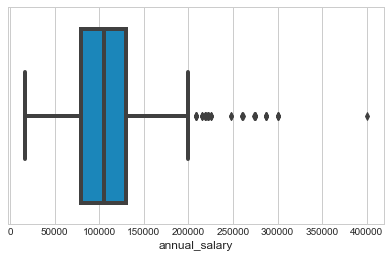

In [49]:
sns.boxplot(df_clean1["annual_salary"])

In [50]:
# Reviewing to see outliers. Identified some had errors i.e. they put per day when per hour. Will drop
df_clean1[["title","annual_salary"]].sort_values(by = "annual_salary",).head(10)

,title,annual_salary
817,data analyst - government education,16965.0
174,data analyst - government education,16965.0
405,software engineer | iot | south east suburbs,23400.0
172,digital analyst,24795.0
546,telesales consultant | $53k + super | temp to ...,25000.0
808,associate professor/professor in computational...,26100.0
93,associate professor/professor in computational...,26100.0
575,senior marketing consultant,28600.0
570,senior marketing consultant,28600.0
1076,solution architect (bi program),28710.0


In [51]:
#Removing Outliers
elements = df_clean1["annual_salary"] 
if elements.dtype != 'object':      
   mean = np.mean(elements, axis=0)
   sd = np.std(elements, axis=0)
   upper= mean + 4 * sd
   lower= mean - 4 * sd
   out = df_clean1[(elements>upper) | (elements<lower)].index.values
   for i in out:
        print('Outliers removed:-------------------------------------------------------')
        print(df_clean1["annual_salary"][i])
        print(df_clean1["title"][i])
   df_clean1["annual_salary"] = df_clean1["annual_salary"].drop(out,axis=0)
   count = len(out)
print('--------------------------------------------------------------------------------')
print('Outliers removed:',count)

Outliers removed:-------------------------------------------------------
300000.0
head of data science - $300k
Outliers removed:-------------------------------------------------------
300000.0
head of data science - $300k
Outliers removed:-------------------------------------------------------
300000.0
head of data science - $300k
Outliers removed:-------------------------------------------------------
300000.0
head of data science - $300k
Outliers removed:-------------------------------------------------------
300000.0
head of data science - $300k
Outliers removed:-------------------------------------------------------
400000.0
bdm job advert
--------------------------------------------------------------------------------
Outliers removed: 6


In [52]:
# Review outliers based on top salary - appears like there are quite a few duplicates. Will need to drop
df_clean1[["title","annual_salary"]].sort_values(by = "annual_salary",ascending = False).head(10)

,title,annual_salary
303,snr data engineer| ml/ai| spark|etl/elt proces...,287100.0
664,snr data engineer| ml/ai| spark|etl/elt proces...,287100.0
1009,snr data engineer| ml/ai| spark|etl/elt proces...,287100.0
877,data engineer,287100.0
836,snr data engineer| ml/ai| spark|etl/elt proces...,287100.0
883,data engineer,287100.0
252,small cap equities research analyst - industrials,275000.0
60,small cap equities research analyst - industrials,275000.0
230,small cap equities research analyst - industrials,275000.0
786,head of big data,275000.0


In [53]:
# Dropping some nulls
df_clean2 = df_clean1[pd.notnull(df_clean1["annual_salary"])]
# Dropping duplicates
df_clean2 = df_clean2[["title_clean","description","annual_salary","city"]]
df_clean2.drop_duplicates(inplace = True)
df_clean3 = df_clean2[["title_clean","description","annual_salary"]]
print(df_clean2.shape)
print(df_clean3.shape)
df_clean4 = df_clean3.drop_duplicates()
print(df_clean4.shape)

(906, 4)
(906, 3)
(906, 3)


In [54]:
# Slightly better
df_clean4.sort_values(by = "annual_salary",ascending = False).head(10)

,title_clean,description,annual_salary
877,6.data_engineer,data engineer job - hudson - sydney nsw | inde...,287100.0
303,6.data_engineer,snr data engineer| ml/ai| spark|etl/elt proces...,287100.0
883,6.data_engineer,data engineer job - hudson - sydney nsw | inde...,287100.0
60,Other,small cap equities research analyst - industri...,275000.0
237,Other,small cap equities research analyst - industri...,275000.0
236,Other,small cap equities research analyst - industri...,275000.0
786,9.bigdata_consult/archtt,head of big data job - fourquarters - melbourn...,275000.0
252,Other,small cap equities research analyst - industri...,275000.0
341,Other,splunk engineer- major australian org - $ per ...,274050.0
552,Other,senior project manager - it transformation job...,261000.0


Text(0.5,1,'Job Salary')

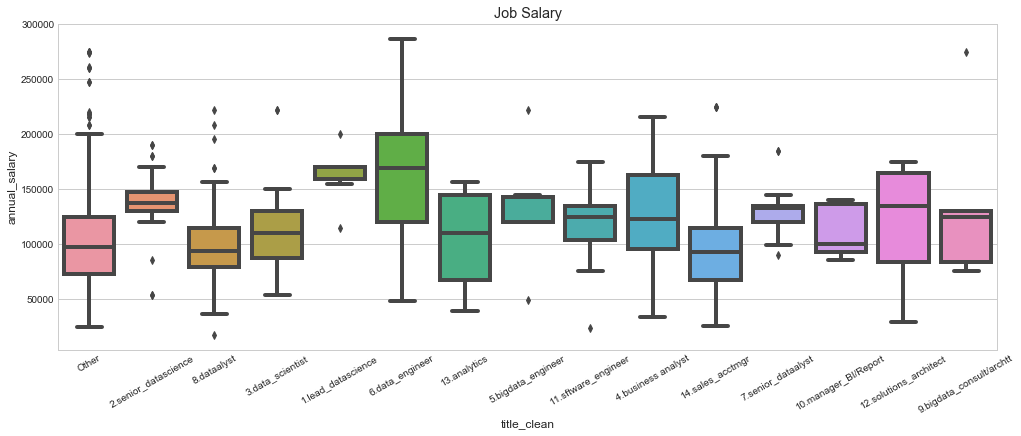

In [55]:
# # Plotting
a4_dims = (15, 6)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
sns.boxplot(x = "title_clean", y = "annual_salary", data = df_clean4).set_title("Job Salary")

In [56]:
df_clean4["annual_salary"].mean()

108246.40673289183

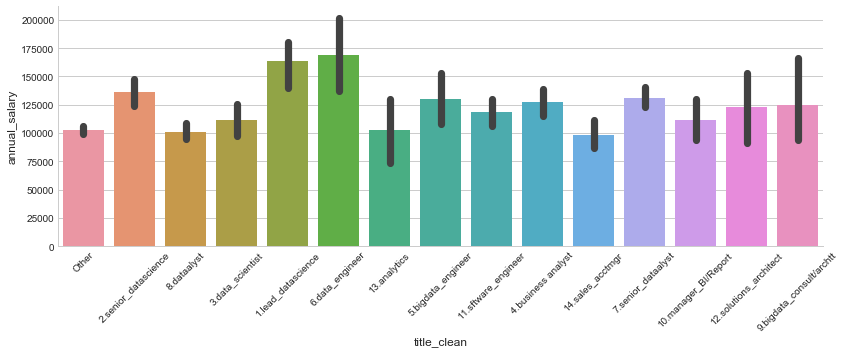

In [57]:
sns.factorplot(x = "title_clean", y = "annual_salary", 
               data = df_clean4, kind = "bar", aspect = 3).set_xticklabels(rotation = 45)

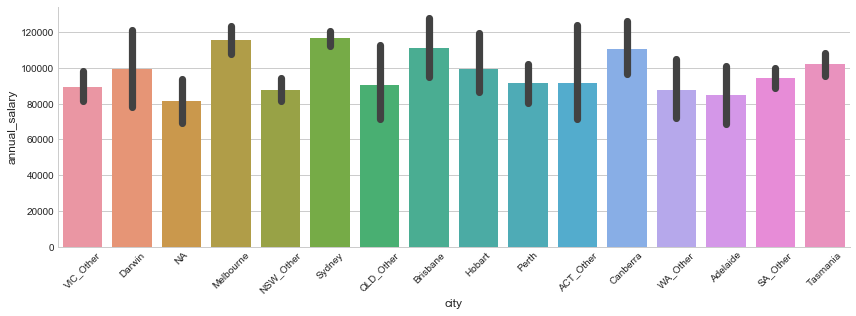

In [58]:
sns.factorplot(x = "city", y = "annual_salary", 
               data = df_clean2, kind = "bar", aspect = 3).set_xticklabels(rotation = 45)

#### Creating Target Variable

Text(0.5,1,'Indeed Salary Distribution with Median (black) and Mean (red)')

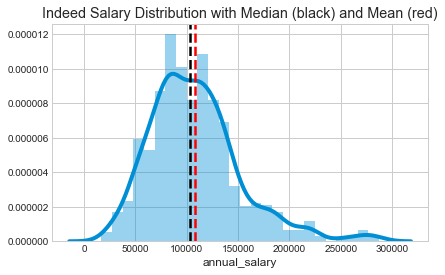

In [59]:
#plotting salary distribution, with vertical lines to represent the mean and median salary
sal_plot = df_clean4[df_clean4["annual_salary"].notnull()]
ax = sns.distplot(sal_plot["annual_salary"])
ax.axvline(sal_plot["annual_salary"].median(), lw=2.5, ls='dashed', color='black')
ax.axvline(sal_plot["annual_salary"].mean(), lw=2.5, ls='dashed', color='red')
plt.title('Indeed Salary Distribution with Median (black) and Mean (red)')

In [60]:
# Use median to characterise salary since the distribution is right skewed
print(df_clean4["annual_salary"].median())
print(df_clean4["annual_salary"].mean())
median = df_clean4["annual_salary"].median()

103379.0
108246.40673289183


In [61]:
df_clean4["Target"] = [1 if x>=df_clean4["annual_salary"].median() else 0 for x in df_clean4["annual_salary"]]

In [62]:
df_clean4.head()

,title_clean,description,annual_salary,Target
0,Other,soil scientist/soil surveyor job - sunraysia e...,80000.0,0
1,Other,chemistry laboratory technician/analyst job - ...,78260.0,0
2,2.senior_datascience,data engineer - machine learning job - csiro -...,128000.0,1
3,8.dataalyst,data analyst job - deloitte - melbourne vic | ...,80000.0,0
4,3.data_scientist,data science research engineer job - macquarie...,106382.0,1


In [63]:
# df_clean4['Target'] = np.where(df_clean4['annual_salary']>=median, 'high', 'low')

In [64]:
df_clean4.head()

,title_clean,description,annual_salary,Target
0,Other,soil scientist/soil surveyor job - sunraysia e...,80000.0,0
1,Other,chemistry laboratory technician/analyst job - ...,78260.0,0
2,2.senior_datascience,data engineer - machine learning job - csiro -...,128000.0,1
3,8.dataalyst,data analyst job - deloitte - melbourne vic | ...,80000.0,0
4,3.data_scientist,data science research engineer job - macquarie...,106382.0,1


In [65]:
df_description = df_clean4["description"]

### NLP
* Based non comparison below, tfidf was not adopted since it did not increase score
* Stop words were added to remove non-value add words such as job, indeed etc
* Lematization was also compared but was not adopted since it did not increase score
* n_grams were analysed in great depth below, assessed to use a combination of 1 and 2 words to capture factors that impact salary and also prediction of job titles. Words such as python and SQL would have been excluded. 2 word ngrams also provide context

In [66]:
#Importing NLP library
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from gensim import corpora, models, matutils
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
import string
import nltk
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

C:\Users\Josh Lim\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [67]:
# Standard scaler
from sklearn.preprocessing import StandardScaler

# Categorical
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV

# Pipeline
from sklearn.pipeline import Pipeline

# Continuous
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

# Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score

#Gridsearch and scoring
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

# Train test
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, chi2, f_classif

C:\Users\Josh Lim\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Josh Lim\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [68]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df_description, df_clean4['Target'], test_size=0.3)

#### Determining whether to use count or tfidf vectorizer

Based on the scores below, we will use count vectorizer

In [69]:
def count_vect_score(X_train, X_test, y_train, y_test, ngrams = (1,2)):
    for model in range(1,3):
        if model == 1:
            print("---------------------------------------------------")
            model = Pipeline([('vect', CountVectorizer(analyzer="word",stop_words='english',ngram_range=ngrams)),('clf', DecisionTreeClassifier()),])
            print("Count vect, Decision Tree")
            print("---------------------------------------------------")
        elif model == 2:
            print("---------------------------------------------------")
            model = Pipeline([('vect', CountVectorizer(analyzer="word",stop_words='english',ngram_range=ngrams)),('clf', RandomForestClassifier()),])
            print("Count vect, Random Forest")

In [70]:
# Function to score count vectorizer and tfidif vectorizer
def count_vect_score(X_train, X_test, y_train, y_test, ngrams = (1,2)):
    for model in range(1,7):
        if model == 1:
            print("---------------------------------------------------")
            model = Pipeline([('vect', CountVectorizer(analyzer="word",stop_words='english',ngram_range=ngrams)),('clf', DecisionTreeClassifier()),])
            print("Count vect, Decision Tree")
            print("---------------------------------------------------")
        elif model == 2:
            print("---------------------------------------------------")
            model = Pipeline([('vect', CountVectorizer(analyzer="word",stop_words='english',ngram_range=ngrams)),('clf', RandomForestClassifier()),])
            print("Count vect, Random Forest")
        elif model == 3:
            print("---------------------------------------------------")
            model = Pipeline([('vect', CountVectorizer(analyzer="word",stop_words='english',ngram_range=ngrams)),('clf', AdaBoostClassifier()),])
            print("Count vect, AdaBoostClassifier")
            print("---------------------------------------------------")
        elif model == 4:
            print("---------------------------------------------------")
            model = Pipeline([('vect', CountVectorizer(analyzer="word",stop_words='english',ngram_range=ngrams)),('clf', MultinomialNB()),])
            print("Count vect, multi NB regression")
            print("---------------------------------------------------")
        elif model == 5:
            print("---------------------------------------------------")
            model = Pipeline([('vect', CountVectorizer(analyzer="word",stop_words='english',ngram_range=ngrams)),('clf', LogisticRegression()),])
            print("Count vect, Logistic Regression")
            print("---------------------------------------------------")
        elif model == 6:
            print("---------------------------------------------------")
            model = Pipeline([('vect', CountVectorizer(analyzer="word",stop_words='english',ngram_range=ngrams)),('clf', SVC(kernel="linear")),])
            print("Count vect, SVC")
            print("---------------------------------------------------")

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(accuracy_score(y_test, predictions).round(3), "ngram","{}".format(ngrams))

def tfidf_vect_score(X_train, X_test, y_train, y_test, ngrams = (1,2)):
    for model in range(1,7):
        if model == 1:
            print("---------------------------------------------------")
            model = Pipeline([('vect', TfidfVectorizer(analyzer="word",stop_words='english',ngram_range=ngrams)),('clf', DecisionTreeClassifier()),])
            print("Tfidf vect, Decision Tree")
            print("---------------------------------------------------")
        elif model == 2:
            print("---------------------------------------------------")
            model = Pipeline([('vect', TfidfVectorizer(analyzer="word",stop_words='english',ngram_range=ngrams)),('clf', RandomForestClassifier()),])
            print("Tfidf vect, Random Forest")
        elif model == 3:
            print("---------------------------------------------------")
            model = Pipeline([('vect', TfidfVectorizer(analyzer="word",stop_words='english',ngram_range=ngrams)),('clf', AdaBoostClassifier()),])
            print("Tfidf vect, AdaBoostClassifier")
            print("---------------------------------------------------")
        elif model == 4:
            print("---------------------------------------------------")
            model = Pipeline([('vect', TfidfVectorizer(analyzer="word",stop_words='english',ngram_range=ngrams)),('clf', MultinomialNB()),])
            print("Tfidf vect, multi NB regression")
            print("---------------------------------------------------")
        elif model == 5:
            print("---------------------------------------------------")
            model = Pipeline([('vect', TfidfVectorizer(analyzer="word",stop_words='english',ngram_range=ngrams)),('clf', LogisticRegression()),])
            print("Tfidf vect, Logistic Regression")
            print("---------------------------------------------------")
        elif model == 6:
            print("---------------------------------------------------")
            model = Pipeline([('vect', TfidfVectorizer(analyzer="word",stop_words='english',ngram_range=ngrams)),('clf', SVC(kernel="linear")),])
            print("Tfidf vect, SVC")
            print("---------------------------------------------------")

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(accuracy_score(y_test, predictions).round(3), "ngram","{}".format(ngrams))

In [71]:
count_vect_score(X_train, X_test, y_train, y_test, ngrams = (2,2))

---------------------------------------------------
Count vect, Decision Tree
---------------------------------------------------
0.724 ngram (2, 2)
---------------------------------------------------
Count vect, Random Forest
0.765 ngram (2, 2)
---------------------------------------------------
Count vect, AdaBoostClassifier
---------------------------------------------------
0.702 ngram (2, 2)
---------------------------------------------------
Count vect, multi NB regression
---------------------------------------------------
0.739 ngram (2, 2)
---------------------------------------------------
Count vect, Logistic Regression
---------------------------------------------------
0.779 ngram (2, 2)
---------------------------------------------------
Count vect, SVC
---------------------------------------------------
0.787 ngram (2, 2)


In [72]:
tfidf_vect_score(X_train, X_test, y_train, y_test, ngrams = (2,2))

---------------------------------------------------
Tfidf vect, Decision Tree
---------------------------------------------------
0.68 ngram (2, 2)
---------------------------------------------------
Tfidf vect, Random Forest
0.684 ngram (2, 2)
---------------------------------------------------
Tfidf vect, AdaBoostClassifier
---------------------------------------------------
0.739 ngram (2, 2)
---------------------------------------------------
Tfidf vect, multi NB regression
---------------------------------------------------
0.706 ngram (2, 2)
---------------------------------------------------
Tfidf vect, Logistic Regression
---------------------------------------------------
0.739 ngram (2, 2)
---------------------------------------------------
Tfidf vect, SVC
---------------------------------------------------
0.794 ngram (2, 2)


#### Determining whether to use stemming or lematisation

In [73]:
# Lemmatisation class
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [74]:
def stem_vect_score(X_train, X_test, y_train, y_test, ngrams = (1,2)):
    for model in range(1,3):
        if model == 1:
            print("---------------------------------------------------")
            model = Pipeline([('vect', CountVectorizer(analyzer="word",stop_words='english',ngram_range=ngrams)),('clf', LogisticRegressionCV(cv = 2)),])
            print("No Lemmatized, LogReg")
            print("---------------------------------------------------")
        if model == 2:
            print("---------------------------------------------------")
            model = Pipeline([('vect', CountVectorizer(analyzer="word",stop_words='english',ngram_range=ngrams, tokenizer=LemmaTokenizer())),('clf', LogisticRegressionCV(cv = 2)),])
            print("Lemmatized, LogReg")
            
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(accuracy_score(y_test, predictions).round(3), "ngram","{}".format(ngrams))           


In [75]:
stem_vect_score(X_train, X_test, y_train, y_test, ngrams = (1,2))

---------------------------------------------------
No Lemmatized, LogReg
---------------------------------------------------
0.787 ngram (1, 2)
---------------------------------------------------
Lemmatized, LogReg
0.79 ngram (1, 2)


#### Word exploration

##### There are many redundant words below

In [76]:
# Frequent words function
def get_freq_words(sparse_counts, columns):
    # X_all is a sparse matrix, so sum() returns a 'matrix' datatype ...
    #   which we then convert into a 1-D ndarray for sorting
    word_counts = np.asarray(X_all.sum(axis=0)).reshape(-1)

    # argsort() returns smallest first, so we reverse the result
    largest_count_indices = word_counts.argsort()[::-1]

    # pretty-print the results! Remember to always ask whether they make sense ...
    freq_words = pd.Series(word_counts[largest_count_indices], 
                           index=columns[largest_count_indices])

    return freq_words

In [77]:
cvt      =  CountVectorizer(analyzer="word",stop_words='english', ngram_range=(1,1))
X_all    =  cvt.fit_transform(df_description)
columns  =  np.array(cvt.get_feature_names())          # ndarray (for indexing below)
print(X_all.shape)
print("Requires {} ints to do a .toarray()!".format(X_all.shape[0] * X_all.shape[1]))
freq_words = get_freq_words(X_all, columns)
# freq_words.to_clipboard()
print(freq_words)

(906, 12228)
Requires 11078568 ints to do a .toarray()!
job                      8757
ago                      4911
apply                    4693
data                     4587
nsw                      4235
sydney                   3909
days                     3813
business                 3056
experience               2887
company                  1994
analyst                  1848
jobs                     1779
work                     1729
easily                   1655
team                     1653
vic                      1574
role                     1568
skills                   1557
melbourne                1516
recruitment              1348
com                      1260
australia                1257
help                     1223
centre                   1204
senior                   1196
development              1152
description              1122
engineer                 1121
like                     1114
resume                   1100
                         ... 
orica         

In [78]:
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ["indeed","job","ago","apply","nsw","sydney","days","experience","company","jobs","work","team","easily","role","vic","skills","melbourne","recruitment","com","help","australia","centre","description","like","resume","city","working","search","state","privacy","post","upload","terms","territory","research","sign","title","ability","keywords","year","save","cookies","resumesemployers","reviewsfind","postcode","jobscompany","salariesfind","reviews","skip","searchclose","yes","day","position","required","sales","original","new","hours","time","including","au"]
stopwords.extend(newStopWords)

In [79]:
cvt      =  CountVectorizer(analyzer="word",stop_words=stopwords, ngram_range=(1,1))
X_all    =  cvt.fit_transform(df_description)
columns  =  np.array(cvt.get_feature_names())          # ndarray (for indexing below)
print(X_all.shape)
print("Requires {} ints to do a .toarray()!".format(X_all.shape[0] * X_all.shape[1]))
freq_words = get_freq_words(X_all, columns)
# freq_words.to_clipboard()
print(freq_words)

(906, 12300)
Requires 11143800 ints to do a .toarray()!
data                     4587
business                 3056
analyst                  1848
please                   1234
senior                   1196
may                      1180
development              1152
engineer                 1121
advanced                 1086
management               1068
find                     1048
application              1045
services                 1043
support                   961
solutions                 870
technical                 846
strong                    845
intelligence              763
developer                 759
information               735
software                  730
customer                  721
within                    713
consultant                685
analysis                  676
digital                   668
technology                660
full                      659
analytics                 658
manager                   653
                         ... 
organsiation  

In [80]:
# Compare with non-stop words
model = Pipeline([('vect', CountVectorizer(analyzer="word",stop_words='english',ngram_range=(2,3))),('clf', LogisticRegression()),])
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions).round(3))
model = Pipeline([('vect', CountVectorizer(analyzer="word",stop_words=stopwords,ngram_range=(2,3))),('clf', LogisticRegression()),])
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions).round(3))

0.79
0.794


### Model
* Experiemented with several models above together with their scores, will fit Naive Bayes, logistic regression and decision tree
* Logistic regression and decision trees have been explored in more detail due to their ability to produce coefficients
* Key predictors of salary related to the seniority "manager", "lead", "executive", as well as skills "data science", "engineer", "machine learning", "project manager", "artificial intelligence"

#### Logistic

Model accuracy scored approximately 83%. Key predictors of salary are:
* Key words from 1 ngram: manager, senior, architect, complex, lead, executive, engineer
* Key words from 2 ngram: data science, machine learning, project manager, data manager, artificial intelligence

In [81]:
# Running logistic

cvt      =  CountVectorizer(analyzer="word",stop_words=stopwords, ngram_range=(1,2))
X_all    =  cvt.fit_transform(df_description)
columns  =  np.array(cvt.get_feature_names())

# Train test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_all, df_clean4['Target'], test_size=0.3)
model = LogisticRegression()
model.fit(X_train1, y_train1)
y_pred = model.predict(X_test1)
print(accuracy_score(y_test1, y_pred))
print(classification_report(y_pred,y_test1))
print(confusion_matrix(y_pred,y_test1))

0.8198529411764706
             precision    recall  f1-score   support

          0       0.88      0.76      0.81       141
          1       0.77      0.89      0.83       131

avg / total       0.83      0.82      0.82       272

[[107  34]
 [ 15 116]]


In [82]:
def list_important_pred_var(data):
    important_pred_var = pd.DataFrame(data, columns = ["coef"], index = columns)
    return important_pred_var.sort_values(["coef"], ascending = False)[:20]
list_important_pred_var(model.coef_.T)

,coef
manager,0.329801
architect,0.266828
bi,0.264273
consulting,0.262322
quantitative,0.250951
senior,0.243497
currently,0.242386
lead,0.235141
end,0.212908
solutions,0.211088


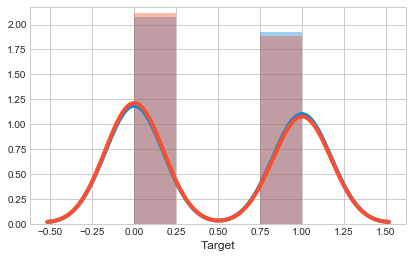

In [83]:
# Selecting as having the best results
sns.distplot(y_pred)
sns.distplot(y_test)

In [84]:
# Running logistic

cvt      =  CountVectorizer(analyzer="word",stop_words=stopwords, ngram_range=(2,2))
X_all    =  cvt.fit_transform(df_description)
columns  =  np.array(cvt.get_feature_names()) 

# Train test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_all, df_clean4['Target'], test_size=0.3)
model = LogisticRegression()
model.fit(X_train1, y_train1)
y_pred = model.predict(X_test1)
print(accuracy_score(y_test1, y_pred))
print(classification_report(y_pred,y_test1))
print(confusion_matrix(y_pred,y_test1))

0.7977941176470589
             precision    recall  f1-score   support

          0       0.81      0.77      0.79       135
          1       0.78      0.82      0.80       137

avg / total       0.80      0.80      0.80       272

[[104  31]
 [ 24 113]]


In [85]:
def list_important_pred_var(data):
    important_pred_var = pd.DataFrame(data, columns = ["coef"], index = columns)
    return important_pred_var.sort_values(["coef"], ascending = False)[:20]
list_important_pred_var(model.coef_.T)

,coef
machine learning,0.349288
senior data,0.335172
advanced senior,0.298192
data manager,0.284414
front end,0.276857
hydrogen group,0.275465
business intelligence,0.257632
data analytics,0.251543
data science,0.250946
may senior,0.246869


In [86]:
# Running logistic

cvt      =  CountVectorizer(analyzer="word",stop_words=stopwords, ngram_range=(3,3))
X_all    =  cvt.fit_transform(df_description)
columns  =  np.array(cvt.get_feature_names())

# Train test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_all, df_clean4['Target'], test_size=0.3)
model = LogisticRegression()
model.fit(X_train1, y_train1)
y_pred = model.predict(X_test1)
print(accuracy_score(y_test1, y_pred))
print(classification_report(y_pred,y_test1))
print(confusion_matrix(y_pred,y_test1))

0.8198529411764706
             precision    recall  f1-score   support

          0       0.76      0.86      0.80       118
          1       0.88      0.79      0.83       154

avg / total       0.83      0.82      0.82       272

[[101  17]
 [ 32 122]]


In [87]:
def list_important_pred_var(data):
    important_pred_var = pd.DataFrame(data, columns = ["coef"], index = columns)
    return important_pred_var.sort_values(["coef"], ascending = False)[:20]
list_important_pred_var(model.coef_.T)

,coef
find advanced senior,0.419320
paxus pty ltd,0.253226
senior project manager,0.245139
senior software engineer,0.238652
senior data analyst,0.223551
paxus paxus pty,0.196928
business analyst data,0.196834
executive office supplies,0.180608
nigel frank international,0.173847
big wave digital,0.173434


#### Decision Tree
Had difficulty tuning the hyperparameters of this model. Model scored approximately 75% accuracy

Key features to predict related again to seniority, as well as skills. The n_gram 2,2 below seems to make more sense.

##### Ngram 1,2

In [88]:
cvt      =  CountVectorizer(analyzer="word",stop_words=stopwords, ngram_range=(1,2))
X_all    =  cvt.fit_transform(df_description)
columns  =  np.array(cvt.get_feature_names())

# Train test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_all, df_clean4['Target'], test_size=0.3)


model = DecisionTreeClassifier()

model.fit(X_train1,y_train1)
y_pred = model.predict(X_test1)
print(accuracy_score(y_test1, y_pred))
print('cross_val_score', cross_val_score(model, X_train1, y_train1, cv=5))
class_report = classification_report(y_pred,y_test1)
print(class_report)
print(confusion_matrix(y_pred,y_test1))

0.7095588235294118
cross_val_score [0.7578125  0.70866142 0.70866142 0.74603175 0.73809524]
             precision    recall  f1-score   support

          0       0.66      0.72      0.69       122
          1       0.76      0.70      0.73       150

avg / total       0.71      0.71      0.71       272

[[ 88  34]
 [ 45 105]]


In [89]:
fi = pd.DataFrame({
        'feature':columns,
        'importance':model.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi.head(30)

,feature,importance
93365,senior,0.083959
10336,aws,0.056135
12153,bi,0.050850
31595,digital,0.033436
101041,successful,0.027243
39048,ethos beathchapman,0.026299
106067,throughout,0.025596
72728,organization,0.025589
82601,proposals,0.024945
112638,welcome,0.022132


##### Ngram 2,2

In [90]:
cvt      =  CountVectorizer(analyzer="word",stop_words=stopwords, ngram_range=(2,2))
X_all    =  cvt.fit_transform(df_description)
columns  =  np.array(cvt.get_feature_names())

# Train test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_all, df_clean4['Target'], test_size=0.3)


model = DecisionTreeClassifier()

model.fit(X_train1,y_train1)
y_pred = model.predict(X_test1)
print(accuracy_score(y_test1, y_pred))
print('cross_val_score', cross_val_score(model, X_train1, y_train1, cv=5))
class_report = classification_report(y_pred,y_test1)
print(class_report)
print(confusion_matrix(y_pred,y_test1))

0.7022058823529411
cross_val_score [0.6875     0.703125   0.65079365 0.75396825 0.70634921]
             precision    recall  f1-score   support

          0       0.61      0.80      0.69       114
          1       0.81      0.63      0.71       158

avg / total       0.73      0.70      0.70       272

[[ 91  23]
 [ 58 100]]


In [91]:
fi = pd.DataFrame({
        'feature':columns,
        'importance':model.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi.head(30)

,feature,importance
2430,advanced senior,0.066433
23875,data entry,0.041778
90404,successful candidates,0.032654
24192,data science,0.026726
67019,paxus pty,0.022090
69369,plus superannuation,0.020896
12668,business intelligence,0.020544
32082,end end,0.017336
88194,stakeholder engagement,0.017213
93027,teams achieve,0.016451


#### KNN
Attempted KNN with gridsearch however result was not that high

In [92]:
cvt      =  CountVectorizer(analyzer="word",stop_words=stopwords, ngram_range=(2,2))
X_all    =  cvt.fit_transform(df_description)
columns  =  np.array(cvt.get_feature_names())

# Train test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_all, df_clean4['Target'], test_size=0.3)

# KNN

knn_params = {
    'n_neighbors':[3,9,21],
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
}

knn_gridsearch = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, verbose=1, n_jobs=-1)

knn_gridsearch.fit(X_train1, y_train1)

knn_gridsearch.best_score_

knn_gridsearch.best_params_

best_knn = knn_gridsearch.best_estimator_
best_knn.score(X_test1, y_test1)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.2min finished


0.6875

In [93]:
y_pred = best_knn.predict(X_test1)
print(accuracy_score(y_test1, y_pred))
class_report = classification_report(y_pred,y_test1)
print(class_report)
print(confusion_matrix(y_pred,y_test1))

0.6875
             precision    recall  f1-score   support

          0       0.40      0.91      0.55        58
          1       0.96      0.63      0.76       214

avg / total       0.84      0.69      0.72       272

[[ 53   5]
 [ 80 134]]


#### Naive Bays

In [94]:
# Pipeline
text_clf = Pipeline([('vect', CountVectorizer(analyzer="word",stop_words=stopwords)),
                     ('tfidf', TfidfTransformer()),('clf', MultinomialNB()),])
# text_clf = text_clf.fit(X_train, y_train)

from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2),(2,2),(2,3)],'tfidf__use_idf': (True, False),'clf__alpha': (1e-2, 1e-3),}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv = 3)
gs_clf = gs_clf.fit(X_train, y_train)
gs_clf.best_score_
gs_clf.best_params_

predictions = gs_clf.predict(X_test)
print(accuracy_score(y_test, predictions))
print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))

0.7573529411764706
             precision    recall  f1-score   support

          0       0.77      0.77      0.77       144
          1       0.74      0.74      0.74       128

avg / total       0.76      0.76      0.76       272

[[111  33]
 [ 33  95]]


In [95]:
cvt      =  CountVectorizer(analyzer="word",stop_words=stopwords, ngram_range=(1,2))
X_all    =  cvt.fit_transform(df_description)
columns  =  np.array(cvt.get_feature_names())

# Train test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_all, df_clean4['Target'], test_size=0.3)

model = MultinomialNB()
model.fit(X_train1, y_train1)

predictions = model.predict(X_test1)
print(accuracy_score(y_test1, predictions))
print(classification_report(predictions,y_test1))
print(confusion_matrix(predictions,y_test1))

0.7867647058823529
             precision    recall  f1-score   support

          0       0.68      0.89      0.77       110
          1       0.91      0.72      0.80       162

avg / total       0.81      0.79      0.79       272

[[ 98  12]
 [ 46 116]]


In [96]:
def list_important_pred_var(data):
    important_pred_var = pd.DataFrame(data, columns = ["coef"], index = columns)
    return important_pred_var.sort_values(["coef"], ascending = False)[:100]
list_important_pred_var(model.coef_.T)

,coef
data,-4.972785
business,-5.373494
analyst,-6.000699
senior,-6.064397
engineer,-6.238679
please,-6.443312
development,-6.508724
management,-6.518092
may,-6.539496
advanced,-6.596371


### Conclusion and key predictors of salary
Overall, the key predictors of salary were skills and seniority based. The model selected was logistic regression which yielded 83% accuracy.

Key predictors are set out below

Prediction vs actual (logistic regression ngram 1,2 83% accuracy)

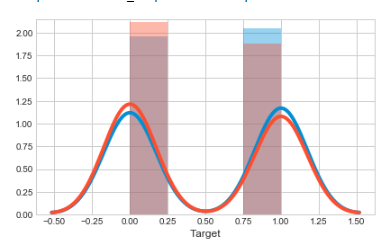

Logistic ngram 1,2

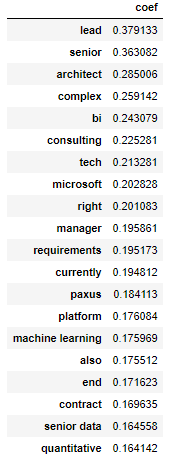



Logistic ngram 2,2
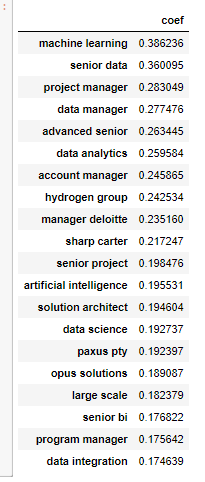

Decision tree 1,2

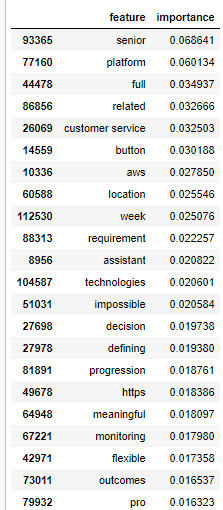

Decision tree 2,2

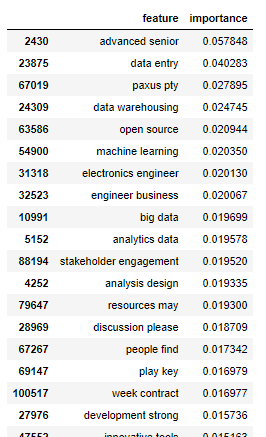

### Prediction of salary continous variable (unsuccessfully)
Attempted predicting continous salary amounts using a few approaches (linear regression with RidgeCVgridsearch, randomforest and SVR. However I was unsuccesful in achieving a strong score. Would be interested to know why.

#### Attempting various continuous models
R2 of various models:
* Linear regression 57%
* Decision tree 29%
* Random Forrest 55%
* Adaboost 29%
* SVR x%

In [97]:
# Train test split
cvt      =  CountVectorizer(analyzer="word",stop_words=stopwords, ngram_range=(1,2))
X_all    =  cvt.fit_transform(df_description)
columns  =  np.array(cvt.get_feature_names())
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_all, df_clean4['annual_salary'], test_size=0.3)

# #Scale features
# ss = StandardScaler()
# X_train = ss.fit_transform(X_train1)
# X_test = ss.transform(X_test)

model = LinearRegression()
model.fit(X_train1, y_train1)

y_pred = model.predict(X_test1)

# Review metrics
from sklearn import metrics
print('cross_val_score', cross_val_score(model, X_train1, y_train1, cv=5))
print('R2 test', metrics.r2_score(y_test1,y_pred))
print('MAE:', metrics.mean_absolute_error(y_test1,y_pred))
print('MSE:', metrics.mean_squared_error(y_test1,y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test1,y_pred)))

cross_val_score [0.47504754 0.53119532 0.42461777 0.4967069  0.48610524]
R2 test 0.5873815665928178
MAE: 17007.662582134348
MSE: 876435240.5552945
RMSE: 29604.64896862137


In [98]:
model = DecisionTreeRegressor()
model.fit(X_train1, y_train1)

y_pred = model.predict(X_test1)

# Review metrics
from sklearn import metrics
print('cross_val_score', cross_val_score(model, X_train1, y_train1, cv=5))
print('R2 test', metrics.r2_score(y_test1,y_pred))
print('MAE:', metrics.mean_absolute_error(y_test1,y_pred))
print('MSE:', metrics.mean_squared_error(y_test1,y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test1,y_pred)))

cross_val_score [ 0.0078552   0.21083628  0.00700352 -0.04370475  0.06684978]
R2 test 0.24029017693015997
MAE: 23180.675735294117
MSE: 1613685690.2788234
RMSE: 40170.7068680503


In [99]:
model = RandomForestRegressor()
model.fit(X_train1, y_train1)

y_pred = model.predict(X_test1)

# Review metrics
from sklearn import metrics
print('cross_val_score', cross_val_score(model, X_train1, y_train1, cv=5))
print('R2 test', metrics.r2_score(y_test1,y_pred))
print('MAE:', metrics.mean_absolute_error(y_test1,y_pred))
print('MSE:', metrics.mean_squared_error(y_test1,y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test1,y_pred)))

cross_val_score [0.41689798 0.42231336 0.39905163 0.40177398 0.37423334]
R2 test 0.541473402581161
MAE: 20620.726273561
MSE: 973947929.062119
RMSE: 31208.138827269388


In [100]:
model = AdaBoostRegressor()
model.fit(X_train1, y_train1)

y_pred = model.predict(X_test1)

# Review metrics
from sklearn import metrics
print('cross_val_score', cross_val_score(model, X_train1, y_train1, cv=5))
print('R2 test', metrics.r2_score(y_test1,y_pred))
print('MAE:', metrics.mean_absolute_error(y_test1,y_pred))
print('MSE:', metrics.mean_squared_error(y_test1,y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test1,y_pred)))

cross_val_score [0.153705   0.18015894 0.22179156 0.19312481 0.21532216]
R2 test 0.29848918236219635
MAE: 29697.340649014983
MSE: 1490066251.1163223
RMSE: 38601.376285261154


In [101]:
model = SVR()
model.fit(X_train1, y_train1)

y_pred = model.predict(X_test1)

# Review metrics
from sklearn import metrics
print('cross_val_score', cross_val_score(model, X_train1, y_train1, cv=5))
print('R2 test', metrics.r2_score(y_test1,y_pred))
print('MAE:', metrics.mean_absolute_error(y_test1,y_pred))
print('MSE:', metrics.mean_squared_error(y_test1,y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test1,y_pred)))

cross_val_score [-5.76066947e-05 -1.01357992e-02 -3.64444349e-03 -5.49811657e-02
 -1.19686629e-01]
R2 test -0.0018110024090676191
MAE: 34271.81707797438
MSE: 2127928361.4090927
RMSE: 46129.473890443325


#### Regularisation
In summary, regularisation here made the score worse, tried ridge (lasso took too long). Would also be keen to understand why, since i thought there might have been too many features/words. Is the way to reduce features in NLP more through stop words/stemming?

In [102]:
#Ridge Calcs
ridge_alphas = np.logspace(0, 5, 500)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=3)
optimal_ridge.fit(X_train1, y_train1)

print(optimal_ridge.alpha_)

98.62521794868779


In [103]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X_train1,y_train1, cv=5)

print(ridge_scores)

print(np.mean(ridge_scores))

[0.51344665 0.53850265 0.42062088 0.53135412 0.48420414]
0.4976256877125536


In [104]:
ridge_coefs = pd.DataFrame({'variable':columns,
                            'coef':optimal_ridge.coef_,
                            'abs_coef':np.abs(optimal_ridge.coef_)})

ridge_coefs.sort_values('coef', inplace=True, ascending=False)
ridge_coefs.head(30)

,abs_coef,coef,variable
23334,2901.670192,2901.670192,contract
97978,2692.327283,2692.327283,splunk
19025,2242.622414,2242.622414,cognos
61485,2180.879998,2180.879998,machine learning
97410,2032.196930,2032.196930,spark
55143,2013.728065,2013.728065,investment
7733,1991.687879,1991.687879,architect
58010,1907.807073,1907.807073,lead
49712,1829.659868,1829.659868,hudson
95863,1712.615833,1712.615833,small cap


##### Lasso

In [105]:
# #Lasso - took too long to execute
# lasso_alphas = np.logspace(0, 5, 500)

# optimal_lasso = LassoCV(alphas = lasso_alphas, cv=5, verbose=1)
# optimal_lasso.fit(X_train1, y_train1)

# print(optimal_lasso.alpha_)

# lasso = Lasso(alpha=optimal_lasso.alpha_)

# lasso_scores = cross_val_score(lasso, X_train1, y_train1, cv=3)

# print(lasso_scores)
# print(np.mean(lasso_scores))

# lasso_coefs = pd.DataFrame({'variable':columns,
#                             'coef':optimal_lasso.coef_,
#                             'abs_coef':np.abs(optimal_lasso.coef_)})

# lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
# lasso_coefs.head(20)

#### Feature selection
Attempted k_best (f_classif) and rfecv. This was more out of interest. Results did not really seem to make sense since it would exclude a great number of valuable words.

##### Kbest

In [106]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

cvt      =  CountVectorizer(analyzer="word",stop_words=stopwords, ngram_range=(1,2))
X_all    =  cvt.fit_transform(df_description)
columns  =  np.array(cvt.get_feature_names())

# build the selector (we'll build one with each score type)
skb_f = SelectKBest(f_classif, k=5)
# skb_chi2 = SelectKBest(chi2, k=5)

# train the selector on our data
skb_f.fit(X_all, df_clean4['annual_salary'].values)
# skb_chi2.fit(X_all, df_clean4['annual_salary'].values)

# examine results
kbest = pd.DataFrame([columns, list(skb_f.scores_)], 
                     index=['feature','f_classif']).T.sort_values('f_classif', ascending=True)
kbest[:60]

C:\Users\Josh Lim\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  UserWarning)
C:\Users\Josh Lim\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\Josh Lim\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,feature,f_classif
90359,risk knowledge,0.0698292
47259,grow customer,0.0699292
27979,defining business,0.0699292
113394,within analytics,0.0699292
103007,systems run,0.0699292
82234,projects development,0.0699292
112849,well tested,0.0699292
93779,server knowledge,0.0699292
29325,design architect,0.0699292
59464,level system,0.0711822


##### RFECV

In [107]:
# Took too long to run
cvt      =  CountVectorizer(analyzer="word",stop_words=stopwords, ngram_range=(1,2))
X_all    =  cvt.fit_transform(df_description)
columns  =  np.array(cvt.get_feature_names())

lr = LinearRegression()
selector = RFECV(lr, step=0.10, cv=2)
selector = selector.fit(X_all, df_clean4['annual_salary'].values)
rfecv_columns = np.array(columns)[selector.support_]
rfecv_columns

array(['abbotsford', 'abbott', 'abbott laboratories', ..., 'zurich',
       'zurich financial', 'zurich insurance'], dtype='<U103')

#### Truncated SVD since PCA not available due to sparse matrix
PCA was not able to be implemented due to sparse Matrix. Overall this approach was not effective, not sure why. Also keen to understand how to use PCA in this situation
http://cs229.stanford.edu/proj2017/final-reports/5163902.pdf

## Question 2
In summary, models were able to predict with 93% accuracy the job title (decision tree and logistic regression)

Job titles have been cleanly classified in the EDA above, resulting in 12 job categories. Based on the job descriptions we have scraped, we would like to predict job categories. This will be a classification problem.

Since this is a multiclass problem, we will use inherently multiclass models such as logistic multinomial, KNN, decision tree, random forest

### EDA
Minimal EDA required since it has been performed in question 1 above.

#### Creating train test data frames

In [108]:
# Use dataframe with job titles
df_title_clean = df_nodup
df_title_clean.head(2)
df_title_clean2 = df_title_clean[["description","title_clean"]]
df_title_clean2.head()

,description,title_clean
0,lead data scientist/data architect - chengdu j...,1.lead_datascience
1,soil scientist/soil surveyor job - sunraysia e...,Other
2,chemistry laboratory technician/analyst job - ...,Other
3,data engineer - machine learning job - csiro -...,2.senior_datascience
4,data analyst job - deloitte - melbourne vic | ...,8.dataalyst


In [109]:
X_traint, X_testt, y_traint, y_testt = train_test_split(df_title_clean2["description"], df_title_clean2["title_clean"], test_size=0.3)

In [110]:
print(X_traint.shape)
print(y_traint.shape)
print(X_testt.shape)

(3958,)
(3958,)
(1697,)


#### Determining whether count vect is better or other
Count vectorizer resulted in higher scores that tfidf, consistent with question 1.

In [111]:
count_vect_score(X_traint, X_testt, y_traint, y_testt, ngrams = (2,2))

---------------------------------------------------
Count vect, Decision Tree
---------------------------------------------------
0.931 ngram (2, 2)
---------------------------------------------------
Count vect, Random Forest
0.895 ngram (2, 2)
---------------------------------------------------
Count vect, AdaBoostClassifier
---------------------------------------------------
0.72 ngram (2, 2)
---------------------------------------------------
Count vect, multi NB regression
---------------------------------------------------
0.847 ngram (2, 2)
---------------------------------------------------
Count vect, Logistic Regression
---------------------------------------------------
0.93 ngram (2, 2)
---------------------------------------------------
Count vect, SVC
---------------------------------------------------
0.935 ngram (2, 2)


In [112]:
tfidf_vect_score(X_traint, X_testt, y_traint, y_testt, ngrams = (2,2))

---------------------------------------------------
Tfidf vect, Decision Tree
---------------------------------------------------
0.922 ngram (2, 2)
---------------------------------------------------
Tfidf vect, Random Forest
0.864 ngram (2, 2)
---------------------------------------------------
Tfidf vect, AdaBoostClassifier
---------------------------------------------------
0.692 ngram (2, 2)
---------------------------------------------------
Tfidf vect, multi NB regression
---------------------------------------------------
0.609 ngram (2, 2)
---------------------------------------------------
Tfidf vect, Logistic Regression
---------------------------------------------------
0.77 ngram (2, 2)
---------------------------------------------------
Tfidf vect, SVC
---------------------------------------------------
0.918 ngram (2, 2)


#### Most common words by job title
Very interesting findings. Here we are able to see the most common words by job titles. Would love to do more analysis here.

In [134]:
# Lets use the stop_words argument to remove words like "and, the, a"
cvec = CountVectorizer(analyzer="word",stop_words=stopwords, ngram_range=(1,1))

# Transforming our x_train data using our fit cvec.
# And converting the result to a DataFrame.
cvec_df = pd.DataFrame(cvec.fit_transform(df_title_clean2["description"]).todense(),
                       columns=cvec.get_feature_names())

# Lets look through some of the categories common words
common_words = []
for i in titles.values:
    word_count = cvec_df[df_title_clean2["title_clean"].values==i].sum(axis=0)
    print(i, "most common words")
    cw = word_count.sort_values(ascending = False).head(50)
    print(cw)

8.dataalyst most common words
data            6685
analyst         3561
business        2698
reporting       1161
analytics        830
management       819
services         780
advanced         775
analysis         771
strong           625
find             615
may              607
support          606
intelligence     589
please           564
solutions        562
group            527
people           516
sql              511
central          503
development      487
district         479
information      475
bi               466
across           441
client           425
within           424
specialist       421
key              417
opportunity      413
site             412
technical        410
tableau          391
projects         389
application      388
marketing        386
knowledge        386
plan             385
systems          378
provide          378
contract         373
quality          372
requirements     372
years            368
using            368
reports          365
fina

architect       672
solution        497
solutions       466
technical       323
business        323
cloud           244
customers       218
services        216
customer        215
data            213
aws             176
technology      162
application     161
development     155
ai              124
enterprise      121
architecture    120
software        114
strong          111
google          111
technologies    110
product         107
management       95
knowledge        93
ibm              91
platform         90
design           89
advanced         86
amazon           85
requirements     83
develop          82
consulting       81
best             80
may              80
related          79
client           79
find             79
learning         78
teams            77
support          76
integration      76
high             75
provide          74
information      74
database         73
site             73
pythian          73
environment      73
please           73
industry         71


### Modelling

#### Logistic Regression
Logistic regression performed well with overall accuracy of 94%. Overall strong classification for most jobs, however there were some jobs that did not perform so well: manager_BI/report, sales_accountmgr

In [115]:
# Performed grid searchcv on logistic regression which yielded the optimal parameters below

cvt      =  CountVectorizer(analyzer="word",stop_words=stopwords, ngram_range=(1,2))
X_allt    =  cvt.fit_transform(df_title_clean2["description"])
columnst  =  np.array(cvt.get_feature_names())

# Train test split
X_traint1, X_testt1, y_traint1, y_testt1 = train_test_split(X_allt, df_title_clean2["title_clean"], test_size=0.3)

model = LogisticRegression(solver='newton-cg', multi_class='multinomial')
model.fit(X_traint1, y_traint1)
y_pred = model.predict(X_testt1)
print(accuracy_score(y_testt1, y_pred))
class_report = classification_report(y_pred,y_testt1)
print(class_report)

0.9493223335297584
                          precision    recall  f1-score   support

      1.lead_datascience       1.00      1.00      1.00        19
    10.manager_BI/Report       0.57      0.67      0.62         6
     11.sftware_engineer       0.94      0.98      0.96        47
  12.solutions_architect       0.88      1.00      0.93        14
            13.analytics       0.67      0.95      0.78        19
        14.sales_acctmgr       0.73      0.89      0.80        63
    2.senior_datascience       0.98      1.00      0.99        45
        3.data_scientist       0.99      0.99      0.99        73
      4.business analyst       0.95      1.00      0.97        88
      5.bigdata_engineer       0.96      1.00      0.98        24
         6.data_engineer       0.95      0.97      0.96        38
      7.senior_dataalyst       0.97      0.94      0.96        34
             8.dataalyst       0.88      0.94      0.91       165
9.bigdata_consult/archtt       0.91      1.00      0.95 

In [125]:
model = LogisticRegression(solver='newton-cg', multi_class='multinomial')
model.fit(X_traint1, y_traint1)
y_pred = model.predict(X_testt1)
print(accuracy_score(y_testt1, y_pred))
class_report = classification_report(y_pred,y_testt1)
print(class_report)

0.9493223335297584
                          precision    recall  f1-score   support

      1.lead_datascience       1.00      1.00      1.00        19
    10.manager_BI/Report       0.57      0.67      0.62         6
     11.sftware_engineer       0.94      0.98      0.96        47
  12.solutions_architect       0.88      1.00      0.93        14
            13.analytics       0.67      0.95      0.78        19
        14.sales_acctmgr       0.73      0.89      0.80        63
    2.senior_datascience       0.98      1.00      0.99        45
        3.data_scientist       0.99      0.99      0.99        73
      4.business analyst       0.95      1.00      0.97        88
      5.bigdata_engineer       0.96      1.00      0.98        24
         6.data_engineer       0.95      0.97      0.96        38
      7.senior_dataalyst       0.97      0.94      0.96        34
             8.dataalyst       0.88      0.94      0.91       165
9.bigdata_consult/archtt       0.91      1.00      0.95 

([<matplotlib.axis.YTick at 0x2c204f716a0>,
 <a list of 15 Text yticklabel objects>)

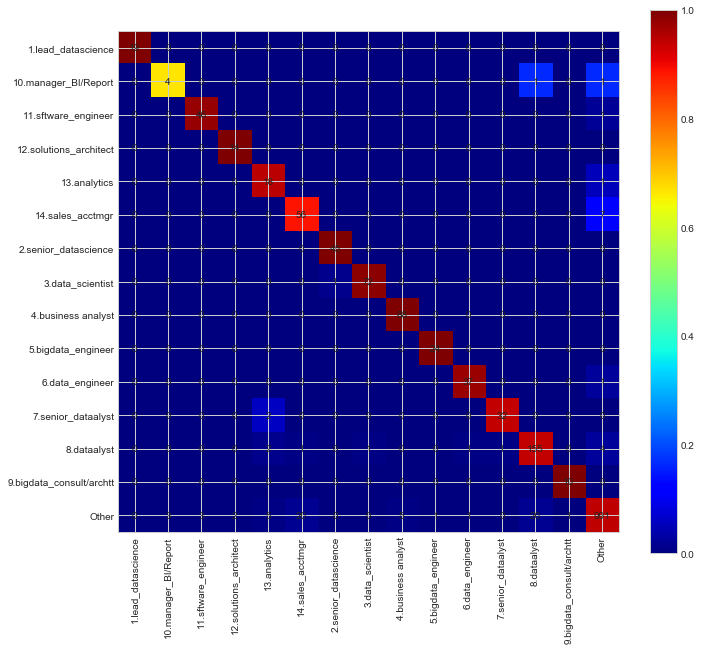

In [116]:
import numpy as np
import matplotlib.pyplot as plt

conf = confusion_matrix(y_pred,y_testt1)

norm_conf = []
for i in conf:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure(figsize=(10,10))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = conf.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')


listx = []
for x in titles.sort_values():
    listx.append(x)
listx 


cb = fig.colorbar(res)

# Resorting job titles to be consistent for plotting


alphabet = listx
plt.xticks(range(width), alphabet[:width], rotation = 90)
plt.yticks(range(height), alphabet[:height])
# plt.savefig('confusion_matrix.png', format='png'

In [117]:
# Function to return logistic regression coefs

def list_important_pred_var(data):
    important_pred_var = pd.DataFrame(data, columns = ["coef"], index = columnst)
    return important_pred_var.sort_values(["coef"], ascending = False)[:30]

# Function to print out coefs based on role unmber above
def role_name_coef(role_num):
    print(listx[role_num])
    return list_important_pred_var(model.coef_[role_num])

In [130]:
role_name_coef(0)

1.lead_datascience


,coef
science,0.254317
data science,0.246447
lead,0.193075
lead data,0.163396
head,0.130618
head data,0.129440
data,0.099758
error,0.090293
leadership,0.089912
customer,0.085428


#### Decision Tree
Overall accuracy was really high. Struggled with predicting: manager_BI/report, solutions architect, sales_account manager

In [119]:
model = DecisionTreeClassifier()
model.fit(X_traint1, y_traint1)
y_pred = model.predict(X_testt1)
print(accuracy_score(y_testt1, y_pred))
class_report = classification_report(y_pred,y_testt1)
print(class_report)
print(confusion_matrix(y_pred,y_testt1))

0.928697701826753
                          precision    recall  f1-score   support

      1.lead_datascience       0.95      1.00      0.97        18
    10.manager_BI/Report       0.71      1.00      0.83         5
     11.sftware_engineer       0.92      1.00      0.96        45
  12.solutions_architect       0.94      0.83      0.88        18
            13.analytics       0.67      0.75      0.71        24
        14.sales_acctmgr       0.77      0.75      0.76        79
    2.senior_datascience       0.93      0.91      0.92        47
        3.data_scientist       0.95      0.97      0.96        71
      4.business analyst       0.91      1.00      0.96        85
      5.bigdata_engineer       0.96      1.00      0.98        24
         6.data_engineer       0.97      0.86      0.92        44
      7.senior_dataalyst       0.88      0.94      0.91        31
             8.dataalyst       0.87      0.92      0.89       166
9.bigdata_consult/archtt       0.73      0.67      0.70  

In [120]:
fi = pd.DataFrame({
        'feature':columnst,
        'importance':model.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi.head(50)

,feature,importance
106035,data,0.120026
54827,business analyst,0.100943
106106,data analyst,0.065701
387252,software engineer,0.053917
371365,scientist,0.038689
388087,solution architect,0.030781
106550,data engineer,0.028222
353256,reporting analyst,0.024727
10105,advanced data,0.023332
47793,big data,0.023247
